In [1]:
import sys, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.signal
import importlib
import h5py
sys.path.append('/Users/ajc/Core/PyScript')
import readdata

In [35]:
path = "/Users/ajc/Core/simulations/barrow_watershed"
outfile ='/Users/ajc/Core/PostProcessing/barrow_watershed/2021/August/set_2/'

In [3]:
colors = ['r','blue','grey','green','darkgreen','k']
marks = ['.','*', '+', 'o']
marks = ['-','-','-','-','-']

SimLabels = ['S%s'%i for i in range(3,0,-1)]

In [4]:
#Set 1 : flow processes
S1 = [os.path.join(path, 'CESM_04/CESM_5050_R1%s_B'%i) for i in range(3)]
S3 = [os.path.join(path, 'CESM_05/CESM_I5050_P80_R3%s'%i) for i in range(1)] 
S5 = [os.path.join(path, 'CESM_05/CESM_I5050_P80_R5%s'%i) for i in range(1)]
Simulations = [S5, S3, S1]
Labels = ['dynamic-microtopography','static-microtopography','no-microtopography']

In [ ]:
# Set 2: ice rich top porosity sensitivity 
S5_P80 = [os.path.join(path, 'CESM_05/CESM_I5050_P80_R5%s'%i) for i in range(1)]
S5_P70 = [os.path.join(path, 'CESM_05/CESM_I5050_P70_R5%s'%i) for i in range(1)]
S5_P90 = [os.path.join(path, 'CESM_05/CESM_I5050_P90_R5%s'%i) for i in range(1)]
Simulations = [S5_P80, S5_P70, S5_P90]
Labels = ['dynamic-microtopography (por = 80%)','dynamic-microtopography (por = 70%)','dynamic-microtopography (por = 90%)']

In [ ]:
# Set 2: ice rich top porosity sensitivity
S5_D0515 = [os.path.join(path, 'CESM_05/CESM_I5050_P80_R5%s'%i) for i in range(1)]
S5_D0020 = [os.path.join(path, 'CESM_05/CESM_I5050_P80_R5%s_D0020'%i) for i in range(1)]
S5_D1010 = [os.path.join(path, 'CESM_05/CESM_I5050_P80_R5%s_D1010'%i) for i in range(1)]
S5_D2020 = [os.path.join(path, 'CESM_05/CESM_I5050_P80_R5%s_D2020'%i) for i in range(1)]
Simulations = [S5_D0515, S5_D0020, S5_D1010,S5_D2020]
Labels = ['dynamic-microtopography (d = [5,15])','dynamic-microtopography (d = [0,2])',
          'dynamic-microtopography (d = [10,10])', 'dynamic-microtopography (d = [20,20])']



In [5]:
sim_len = len(Simulations)
sim_len

3

In [6]:
#path_sf ="/Users/ajc/Core/simulations/projections/barrow_watershed_02/CESM_15/CESM_5050_R60_B/visdump_surface_star_data.h5"
#file_surf= h5py.File(path_sf,'r')
#surface_area = np.sum(list(file_surf['surface_star-cell_volume.cell.0']['100095']))
surface_area = 112635.47903126487
print (surface_area)
molar_density = 55500.

112635.47903126487


In [7]:
def read_file(file):
    d = np.loadtxt(file,usecols=1,skiprows=6)
    t1 = np.loadtxt(file,usecols=0,skiprows=6)
    t = np.array([x/86400./365. for x in t1])
    #print (len(d),len(t))
    l = np.minimum(len(d),len(t))
    return d[:l],t[:l]

def read_set(set,var='surface_flux-halfday.dat'):
    dat = []
    tim = []
    for s in set:
        file = os.path.join(path,s, var)
        #print (file)
        d = np.loadtxt(file,usecols=1,skiprows=6)
        t1 = np.loadtxt(file,usecols=0,skiprows=6)
        t = np.array([x/86400./365. for x in t1])
        
        L = len(d)%(365*2)
        if L >0:
            d = d[:-L]
            t = t[:len(d)]
            
        dat.append(d)
        tim.append(t)
    dat = np.concatenate(dat)
    tim = np.concatenate(tim)
    
    return dat, tim


In [8]:
def get_vars_names(simul):
    names = dict()
    #file = os.path.join(Simulations[0][0],'data_collection.dat')
    file = os.path.join(simul,'data_collection.dat')
    with open(file) as fd:
        count = 0
        for f in fd:
            if ('Observation Name' in f):
                f1 = f.split(':')
                #print (f1, f[-1])
                if 'time [d]' in f1[-1]:
                    names['Time'] = count
                    #print (f1, f1[-1],names)
                elif 'outlet discharge [mol d^-1]' in f1[-1]:
                    names['Discharge'] = count 
                elif 'total evaporation [m d^-1]' in f1[-1]:
                    names['ET'] = count
                elif 'snow precipitation [m d^-1]' in f1[-1]:
                    names['Psnow'] = count
                elif 'rain precipitation [m d^-1]' in f1[-1]:
                    names['Prain'] = count
                elif 'subsurface water content [mol]' in f1[-1]:
                    names['SS_wc'] = count
                    #print (count)
                elif 'surface water content [mol]' in f1[-1]:
                    #print (count)
                    names['Sf_wc'] = count
                elif 'snow water content [mol]' in f1[-1]: #but this is in m^3 correction
                    names['Snow_wc'] = count
                elif 'surface air temperature [K]' in f1[-1]:
                    names['Tair'] = count
                elif 'surface carbon decomposition rate [-]' in f1[-1]:
                    names['Sf_CDR'] = count
                elif 'surface moisture content [-]' in f1[-1]:
                    names['Sf_mc'] = count
                elif 'surface gas content [-]' in f1[-1]:
                    names['Sf_gc'] = count
                elif 'surface volumetric wc [-]' in f1[-1]:
                    names['Sf_vol_wc'] = count
                elif 'surface gas content [-]' in f1[-1]:
                    names['Sf_gc'] = count
                elif 'surface column average temperature [K]' in f1[-1]:
                    names['Sf_avg_T'] = count
                elif 'surface ALT average temperature [K]' in f1[-1]:
                    names['Sf_ALT_avg_T'] = count
                elif 'surface saturated_fraction [-]' in f1[-1]:
                    names['Sf_sat_frac'] = count
                elif 'surface thaw depth min [m]' in f1[-1]:
                    names['Sf_TD_min'] = count
                elif 'surface thaw depth max [m]' in f1[-1]:
                    names['Sf_TD_max'] = count
                elif 'surface maximum thaw depth [m]' in f1[-1]:
                    names['Sf_maxTD'] = count
                elif 'surface water table [m]' in f1[-1]:
                    names['Sf_WT'] = count
                elif 'surface subsurface exchange [m]' in f1[-1]:
                    names['Sf_exchangeFlux'] = count
                elif 'surface initial elevation [m]' in f1[-1]:
                    names['Sf_InitElev'] = count
                elif 'surface mean subsidence [m]' in f1[-1]:
                    names['Sf_mean_Subsidence'] = count
                else:
                    #names['Sf_DNE_%s'%count] = count
                    print ('DNE:',count, f[-1])
                count = count + 1
    return names

In [9]:
#forcing = h5py.File("/Users/ajc/FUSE/simulations/production/barrow_watershed/data/CESM/CESM-RCP8_5-2006-2100_snowadjusted_supersmoothDM_2006.h5",'r')
forcing_watershed_FM = h5py.File("/Users/ajc/Core/PreProcessing/ats-intermediate-ngee/data/SNAP/CESM-RCP8.5-2006-2100_dm1985-2015-FM_2006.h5",'r')

270.79911974314734 473.57967439800024 (array([1]),) (array([19]),)
473.57967439800024 28 473.57967439800024
125.73579507761184 10 125.73579507761184
125.73579507761184 20 265.0558705193602


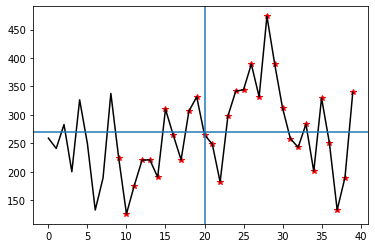

In [10]:
d1 = forcing_watershed_FM['precipitation rain [m s^-1]']
d2 = forcing_watershed_FM['precipitation snow [m SWE s^-1]']
rain_mm = np.reshape(d1,(-1,365)).mean(axis=1)*86400*365*1000
snow_mm = np.reshape(d2,(-1,365)).mean(axis=1)*86400*365*1000
precip_annual = snow_mm + rain_mm
r1 = np.array(d1)*86400*1000
r2 = np.array(d2)*86400*1000
precip_daily = r1 + r2

s= 9 
e = s + 31
pmax,pmin = np.max(precip_annual[s:e]), np.min(precip_annual[s:e])
print (np.mean(precip_annual[s:e]), np.max(precip_annual[s:e]), np.where(precip_annual[s:e]== pmin), np.where(precip_annual[s:e]== pmax))
print (pmax, s+19, precip_annual[28])
print (pmin, s+1, precip_annual[10])
print (pmin, s+11, precip_annual[20]) #typical
x3 = np.arange(s,e,1)
#print(x3)
plt.plot(x3,precip_annual[s:e],'r*')
plt.plot(precip_annual[:e],'k')
plt.axhline(270)
plt.axvline(20)

In [11]:
#Read discharge

time = 2006 + np.linspace(0,94,94,dtype='int')
to_day_mm = 86400 * 1000
to_year_mm = 86400 * 365 * 1000
basin_area = 112635.48
to_mm = 1000.

In [12]:
def get_daily_data():
    daily = dict()
    for i,sim in enumerate(Simulations):
        df = pd.DataFrame(columns=[''])
        #df.columns = names.keys()
        
        for s in sim:
            file = os.path.join(s,'data_collection.dat')
            
            df1 = pd.read_csv(file, comment='#')
            names = get_vars_names(s)
            #print (names)
            print (s, len(names.keys()))
            df1.columns = names.keys()
            #print (names.keys())
            rows,cols = df1.shape
            rows = rows - rows%365.
            df1 = df1.truncate(before=0,after=rows-1,axis='index')
            #break
            df = df.append(df1)
            #print (df)
        daily[SimLabels[i]] = df
        
    return daily

SimData_daily = get_daily_data()
print (SimData_daily['S1'].keys())
print (SimData_daily['S2'].keys())
print (SimData_daily['S3'].keys())

/Users/ajc/Core/simulations/barrow_watershed/CESM_05/CESM_I5050_P80_R50 23
/Users/ajc/Core/simulations/barrow_watershed/CESM_05/CESM_I5050_P80_R30 21
/Users/ajc/Core/simulations/barrow_watershed/CESM_04/CESM_5050_R10_B 16
/Users/ajc/Core/simulations/barrow_watershed/CESM_04/CESM_5050_R11_B 16
/Users/ajc/Core/simulations/barrow_watershed/CESM_04/CESM_5050_R12_B 16
Index(['', 'Time', 'Discharge', 'ET', 'Psnow', 'Prain', 'Sf_wc', 'SS_wc',
       'Snow_wc', 'Tair', 'Sf_CDR', 'Sf_mc', 'Sf_gc', 'Sf_vol_wc', 'Sf_avg_T',
       'Sf_ALT_avg_T', 'Sf_sat_frac'],
      dtype='object')
Index(['', 'Time', 'Discharge', 'ET', 'Psnow', 'Prain', 'Sf_wc', 'SS_wc',
       'Snow_wc', 'Tair', 'Sf_CDR', 'Sf_mc', 'Sf_gc', 'Sf_vol_wc', 'Sf_avg_T',
       'Sf_ALT_avg_T', 'Sf_sat_frac', 'Sf_TD_min', 'Sf_TD_max', 'Sf_maxTD',
       'Sf_WT', 'Sf_exchangeFlux'],
      dtype='object')
Index(['', 'Time', 'Discharge', 'ET', 'Psnow', 'Prain', 'Sf_wc', 'SS_wc',
       'Snow_wc', 'Tair', 'Sf_CDR', 'Sf_mc', 'Sf_gc', 'Sf_v

In [13]:
def getSurfaceData():
    Data = []
    var ='surface_star-thaw_depth'
    for i,sim in enumerate(Simulations[2]):

        infile = os.path.join(sim,'ats_vis_surface_star_data.h5')
        dx=h5py.File(infile,'r')
        Dat11 = np.array(readdata.GetSurfVarFromVis_All(infile,var)[var])
        Dat11 = Dat11.max(axis=1)
        a1 = len(Dat11)%365
        a2 = len(Dat11) - a1

        Dat = Dat11[:a2]
        Data.append(Dat)

    #d = dict()
    #d[var] = np.concatenate(Data)
    d = np.concatenate(Data)
    
    return d

In [14]:
SimData_daily['S1']['Sf_TD_max'] = getSurfaceData()

In [15]:
#print (SimData_daily)
to_year = 365
to_mm = 1000
def get_discharge():
    Q_daily = dict()
    Q_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    print (SimData_daily.keys(),keys)
    for i in range(size):
        convert = 1/(molar_density*surface_area)
        d = [x* convert for x in SimData_daily[keys[i]]['Discharge'] ]
        Q_daily[keys[i]]= d*to_mm
        #print (d.shape)
        Q_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)*to_year * to_mm
    return Q_daily, Q_annual
Q_daily, Q_annual = get_discharge()


def get_time():
    T_daily = dict()
    T_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    print (SimData_daily.keys(),keys)
    for i in range(size):
        convert = 1./(365)
        d = [1985 + x* convert for x in SimData_daily[keys[i]]['Time'] ]
        T_daily[keys[i]]= d
        T_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)
    return T_daily, T_annual
T_daily, T_annual = get_time()

dict_keys(['S3', 'S2', 'S1']) ['S3', 'S2', 'S1']
dict_keys(['S3', 'S2', 'S1']) ['S3', 'S2', 'S1']


In [16]:
def get_ET():
    ET_daily = dict()
    ET_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    #print (SimData_daily.keys(),keys)
    for i in range(size):
        convert = 1
        d = [x* convert for x in SimData_daily[keys[i]]['ET'] ]
        ET_daily[keys[i]]= d*to_mm
        ET_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)*to_year * to_mm
    return ET_daily, ET_annual
ET_daily, ET_annual = get_ET()

In [17]:
def get_saturated_fraction():
    SFrac_daily = dict()
    SFrac_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    for i in range(size):
        convert = 1
        d = [x* convert for x in SimData_daily[keys[i]]['Sf_sat_frac'] ]
        SFrac_daily[keys[i]]= d
        SFrac_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)
    return SFrac_daily, SFrac_annual
SFrac_daily, SFrac_annual = get_saturated_fraction()


def get_ave_TD():
    ATD_daily = dict()
    ATD_annual = dict()
    ATDmin_annual = dict()
    ATDmax_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    
    for i in range(size):
        dmax = np.array([x for x in SimData_daily[keys[i]]['Sf_TD_max'] ])
        
        dd = np.reshape(dmax,(-1,365))#.mean(axis=1)
        dat = []
        for d2 in dd:
            x2 = np.mean(d2[np.nonzero(d2)])
            dat.append(x2)
        ATD_annual[keys[i]] = dat

    return ATD_daily, ATD_annual
ATD_daily, ATD_annual = get_ave_TD()

In [18]:
def get_Carbon():
    CDR_daily = dict()
    CDR_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    for i in range(size):
        convert = 1#/(molar_density*surface_area)
        d = [x * convert for x in SimData_daily[keys[i]]['Sf_CDR'] ] 
        CDR_daily[keys[i]]= d#*to_mm
        CDR_annual[keys[i]]= np.reshape(d,(-1,365)).sum(axis=1)#*to_year #* to_mm
    return CDR_daily, CDR_annual
CDR_daily, CDR_annual = get_Carbon()


# Typical year

In [32]:
#Typical year
cesm_years_typ = [2015+11, 2015 + 11 +31, 2015 + 11 +31*2] 
years_typ = [x - 2006 for x in cesm_years_typ]

#wet year loop
cesm_years_wet = [2015+19, 2015 + 19 +31, 2015 + 19 +31*2] 
years_wet = [x - 2006 for x in cesm_years_wet]

cesm_years_dry = [2015+1, 2015 + 1 +31, 2015 + 1 +31*2] 
years_dry = [x - 2006 for x in cesm_years_dry]

Years_o = [cesm_years_wet, cesm_years_dry, cesm_years_typ]
Years = [years_wet, years_dry, years_typ]

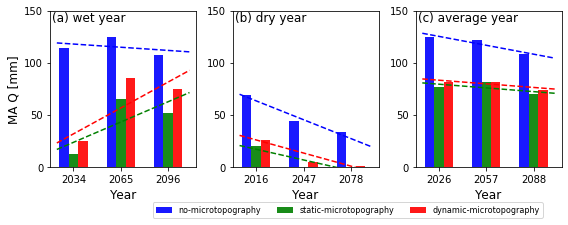

In [61]:
fig, axs = plt.subplots(1,3, figsize=(8,3), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1,1,1]})
fig.subplots_adjust(hspace =.02, wspace=1.02)
plt.tight_layout()
axs = axs.ravel()

x = np.arange(0,3,1)
Colors = ['r', 'g', 'b','grey']

# Discharge
for k in range(3):
    for i1, i in enumerate([2,1,0]):
        s = SimLabels[i]
        d = []
        for k1, k2 in enumerate(Years[k]):
            d.append(Q_annual[s][k2])
        xx = x + i1*0.2
        axs[k].bar(xx, height=d, width=0.2,color=Colors[i],alpha=0.9,label=Labels[i])

        pc = np.polyfit(xx, d, 1)
        p = np.poly1d(pc)
        xxx = np.arange(-.15,2.7,0.1)
        axs[k].plot(xxx,p(xxx),color=Colors[i], linestyle='--')

    axs[0].set_ylabel('MA Q [mm]',fontsize=12, fontweight='normal')
    axs[k].set_xlabel('Year',fontsize=12, fontweight='normal')
    axs[k].set_xticks(x+0.2)
    axs[k].set_xticklabels(Years_o[k])

    axs[k].set_yticks(np.arange(0,150.01,50))
    axs[k].set_ylim(0,150)
#axs[1].set_yticks([])
plt.tight_layout()
axs[2].legend(loc='upper right', fontsize=8, ncol=3, bbox_to_anchor=(0.8,-0.3, .1, .1))
#plt.tight_layout()
A = ['(a) wet year', '(b) dry year','(c) average year']
loc = [[-0.25,140] for i in [-0.25,137,0.77,1.33]]
for i in range(3):
    axs[i].text(loc[i][0],loc[i][1],'%s'%A[i],fontsize=12)
#plt.tight_layout()
plt.savefig(outfile+'/Q_wet_dry_avg.pdf', bbox_inches='tight', dpi=500)

# Wet Year

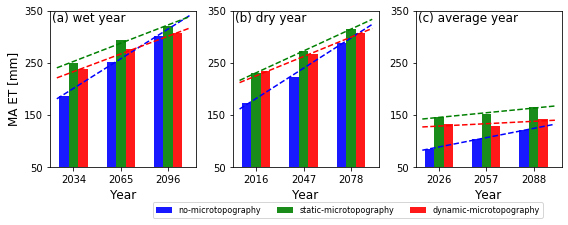

In [68]:
fig, axs = plt.subplots(1,3, figsize=(8,3), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1,1,1]})
fig.subplots_adjust(hspace =.02, wspace=1.02)
plt.tight_layout()
axs = axs.ravel()

x = np.arange(0,3,1)
Colors = ['r', 'g', 'b','grey']

# Discharge
for k in range(3):
    for i1, i in enumerate([2,1,0]):
        s = SimLabels[i]
        d = []
        for k1, k2 in enumerate(Years[k]):
            d.append(ET_annual[s][k2])
        xx = x + i1*0.2
        axs[k].bar(xx, height=d, width=0.2,color=Colors[i],alpha=0.9,label=Labels[i])

        pc = np.polyfit(xx, d, 1)
        p = np.poly1d(pc)
        xxx = np.arange(-.15,2.7,0.1)
        axs[k].plot(xxx,p(xxx),color=Colors[i], linestyle='--')

    axs[0].set_ylabel('MA ET [mm]',fontsize=12, fontweight='normal')
    axs[k].set_xlabel('Year',fontsize=12, fontweight='normal')
    axs[k].set_xticks(x+0.2)
    axs[k].set_xticklabels(Years_o[k])

    axs[k].set_yticks(np.arange(50,351,100))
    axs[k].set_ylim(50,350)

plt.tight_layout()
axs[2].legend(loc='upper right', fontsize=8, ncol=3, bbox_to_anchor=(0.8,-0.3, .1, .1))
#plt.tight_layout()
A = ['(a) wet year', '(b) dry year','(c) average year']
loc = [[-0.25,330] for i in [-0.25,137,0.77,1.33]]
for i in range(3):
    axs[i].text(loc[i][0],loc[i][1],'%s'%A[i],fontsize=12)
#plt.tight_layout()
plt.savefig(outfile+'/ET_wet_dry_avg.pdf', bbox_inches='tight', dpi=500)

In [ ]:
#wet year loop
cesm_years_o = [2015+19, 2015 + 19 +31, 2015 + 19 +31*2] 
cesm_years = [x - 2006 for x in cesm_years_o]

print (cesm_years)
print (precip_annual[cesm_years], )

fig, axs = plt.subplots(2,2, figsize=(8,6), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1,1]})
fig.subplots_adjust(hspace =.02, wspace=1.02)
plt.tight_layout()
axs = axs.ravel()

x = np.arange(0,3,1)
Colors = ['r', 'g', 'b','grey']

# Discharge
#dat = []
for i1, i in enumerate([2,1,0]):
    s = SimLabels[i]
    d = []
    d1 = get_moving_average(Q_annual[s],m=1)
    for k1,k in enumerate(cesm_years):
        d.append(Q_annual[s][k])
    xx = x + i1*0.2
    axs[0].bar(xx, height=d, width=0.2,color=Colors[i],alpha=0.9,label=Labels[i])

    pc = np.polyfit(xx, d, 1)
    p = np.poly1d(pc)
    xxx = np.arange(-.15,2.7,0.1)
    axs[0].plot(xxx,p(xxx),color=Colors[i], linestyle='--')

axs[0].set_ylabel('MA Q [mm]',fontsize=12, fontweight='normal')
axs[0].set_xticks(x+0.2)
axs[0].set_xticklabels(cesm_years_o)
axs[0].set_ylim(0,150)
axs[0].set_yticks(np.arange(0,150.01,50))

# ET
dat = []
for i1, i in enumerate([2,1,0]):
    s = SimLabels[i]
    d = []

    for k1,k in enumerate(cesm_years):
        d.append(ET_annual[s][k])

    xx = x + i1*0.2
    pc = np.polyfit(xx, d, 1)
    p = np.poly1d(pc)
    xxx = np.arange(-.15,2.7,0.1)

    axs[1].bar(xx, height=d, width=0.2,color=Colors[i],alpha=0.9,label=Labels[i])
    axs[1].plot(xxx,p(xxx),color=Colors[i], linestyle='--')
axs[1].set_ylabel('MA ET [mm]',fontsize=12, fontweight='normal')
axs[1].set_xticks(x+0.2)
axs[1].set_xticklabels(cesm_years_o)
axs[1].set_yticks(np.arange(200,351,50))
axs[1].set_ylim(150,350)

# Saturated Fraction
for i1, i in enumerate([2,1,0]):
    s = SimLabels[i]
    d = []
    for k1,k in enumerate(cesm_years):
        
        #d.append(SFrac_annual[s][k]/ATD_annual[s][k])
        d.append(SFrac_annual[s][k])

    xx = x + i1*0.2
    pc = np.polyfit(xx, d, 1)
    p = np.poly1d(pc)
    xxx = np.arange(-.15,2.7,0.1)

    axs[2].bar(xx, height=d, width=0.2,color=Colors[i],alpha=0.9,label=Labels[i])
    axs[2].plot(xxx,p(xxx),color=Colors[i], linestyle='--')

#axs[2].set_ylabel('MA SF [m$^{-1}$]',fontsize=12, fontweight='normal')
axs[2].set_ylabel('MA SF [-]',fontsize=12, fontweight='normal')

axs[2].set_xticks(x+0.2)
axs[2].set_xticklabels(cesm_years_o)
axs[2].set_yticks(np.arange(0.3,0.801,0.1))
axs[2].set_ylim(0.3,0.8)

# MA Thaw depth
for i1, i in enumerate([2,1,0]):
    s = SimLabels[i]
    d = []
    for k1,k in enumerate(cesm_years):
        #print (k1, k, s)
        d.append(ATD_annual[s][k])

    xx = x + i1*0.2
    pc = np.polyfit(xx, d, 1)
    p = np.poly1d(pc)
    xxx = np.arange(-.15,2.7,0.1)
    print (d)
    axs[3].bar(xx, height=d, width=0.2,color=Colors[i],alpha=0.9,label=Labels[i])
    axs[3].plot(xxx,p(xxx),color=Colors[i], linestyle='--')

#plt.legend()
axs[3].set_ylabel('MA TD [m]',fontsize=12, fontweight='normal')
axs[3].set_xlabel('Year',fontsize=12, fontweight='normal')
axs[2].set_xlabel('Year',fontsize=12, fontweight='normal')
axs[3].set_xticks(x+0.2)
axs[3].set_xticklabels(cesm_years_o)
#axs[2].set_yticks(np.arange(0.4,0.801,0.1))
axs[3].set_ylim(0.4,1.8)
axs[3].legend(loc='upper right', fontsize=10, ncol=3, bbox_to_anchor=(0.8,-0.26, .1, .1))

A = ['a', 'b','c', 'd']
loc = [[-0.25,i] for i in [137,332,0.85,1.665]]
for i in range(4):
    axs[i].text(loc[i][0],loc[i][1],'(%s)'%A[i],fontsize=12)
    
plt.savefig(outfile+'/Q_ET_SF_TD-wetyear.pdf', bbox_inches='tight', dpi=500)




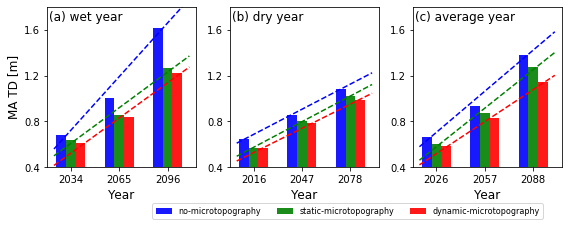

In [95]:
fig, axs = plt.subplots(1,3, figsize=(8,3), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1,1,1]})
fig.subplots_adjust(hspace =.02, wspace=1.02)
plt.tight_layout()
axs = axs.ravel()

x = np.arange(0,3,1)
Colors = ['r', 'g', 'b','grey']

# Discharge
for k in range(3):
    for i1, i in enumerate([2,1,0]):
        s = SimLabels[i]
        d = []
        for k1, k2 in enumerate(Years[k]):
            d.append(ATD_annual[s][k2])
        xx = x + i1*0.2
        axs[k].bar(xx, height=d, width=0.2,color=Colors[i],alpha=0.9,label=Labels[i])

        pc = np.polyfit(xx, d, 1)
        p = np.poly1d(pc)
        xxx = np.arange(-.15,2.7,0.1)
        axs[k].plot(xxx,p(xxx),color=Colors[i], linestyle='--')

    axs[0].set_ylabel('MA TD [m]',fontsize=12, fontweight='normal')
    axs[k].set_xlabel('Year',fontsize=12, fontweight='normal')
    axs[k].set_xticks(x+0.2)
    axs[k].set_xticklabels(Years_o[k])

    axs[k].set_yticks(np.arange(0.4,1.801,0.4))
    axs[k].set_ylim(0.4,1.8)

plt.tight_layout()
axs[2].legend(loc='upper right', fontsize=8, ncol=3, bbox_to_anchor=(0.8,-0.3, .1, .1))
#plt.tight_layout()
A = ['(a) wet year', '(b) dry year','(c) average year']
loc = [[-0.25,1.68] for i in [-0.25,137,0.77,1.33]]
for i in range(3):
    axs[i].text(loc[i][0],loc[i][1],'%s'%A[i],fontsize=12)
#plt.tight_layout()
plt.savefig(outfile+'/TD_wet_dry_avg.pdf', bbox_inches='tight', dpi=500)

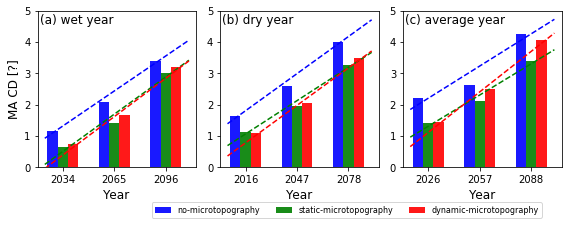

In [94]:
fig, axs = plt.subplots(1,3, figsize=(8,3), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1,1,1]})
fig.subplots_adjust(hspace =.02, wspace=1.02)
plt.tight_layout()
axs = axs.ravel()

x = np.arange(0,3,1)
Colors = ['r', 'g', 'b','grey']

# Discharge
for k in range(3):
    for i1, i in enumerate([2,1,0]):
        s = SimLabels[i]
        d = []
        for k1, k2 in enumerate(Years[k]):
            d.append(CDR_annual[s][k2])
        xx = x + i1*0.2
        axs[k].bar(xx, height=d, width=0.2,color=Colors[i],alpha=0.9,label=Labels[i])

        pc = np.polyfit(xx, d, 1)
        p = np.poly1d(pc)
        xxx = np.arange(-.15,2.7,0.1)
        axs[k].plot(xxx,p(xxx),color=Colors[i], linestyle='--')

    axs[0].set_ylabel('MA CD [?]',fontsize=12, fontweight='normal')
    axs[k].set_xlabel('Year',fontsize=12, fontweight='normal')
    axs[k].set_xticks(x+0.2)
    axs[k].set_xticklabels(Years_o[k])

    axs[k].set_yticks(np.arange(0.0,5.001,1.0))
    axs[k].set_ylim(0.0,5.0)

plt.tight_layout()
axs[2].legend(loc='upper right', fontsize=8, ncol=3, bbox_to_anchor=(0.8,-0.3, .1, .1))
#plt.tight_layout()
A = ['(a) wet year', '(b) dry year','(c) average year']
loc = [[-0.25,4.6] for i in [-0.25,137,0.77,1.33]]
for i in range(3):
    axs[i].text(loc[i][0],loc[i][1],'%s'%A[i],fontsize=12)
#plt.tight_layout()
plt.savefig(outfile+'/CD_wet_dry_avg.pdf', bbox_inches='tight', dpi=500)

# Dry Year

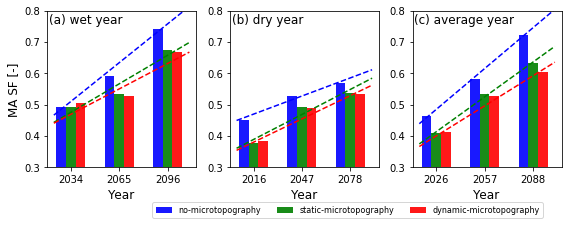

In [102]:
fig, axs = plt.subplots(1,3, figsize=(8,3), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1,1,1]})
fig.subplots_adjust(hspace =.02, wspace=1.02)
plt.tight_layout()
axs = axs.ravel()

x = np.arange(0,3,1)
Colors = ['r', 'g', 'b','grey']

# Discharge
for k in range(3):
    for i1, i in enumerate([2,1,0]):
        s = SimLabels[i]
        d = []
        for k1, k2 in enumerate(Years[k]):
            d.append(SFrac_annual[s][k2])
        xx = x + i1*0.2
        axs[k].bar(xx, height=d, width=0.2,color=Colors[i],alpha=0.9,label=Labels[i])

        pc = np.polyfit(xx, d, 1)
        p = np.poly1d(pc)
        xxx = np.arange(-.15,2.7,0.1)
        axs[k].plot(xxx,p(xxx),color=Colors[i], linestyle='--')

    axs[0].set_ylabel('MA SF [-]',fontsize=12, fontweight='normal')
    axs[k].set_xlabel('Year',fontsize=12, fontweight='normal')
    axs[k].set_xticks(x+0.2)
    axs[k].set_xticklabels(Years_o[k])

    axs[k].set_yticks(np.arange(0.3,0.801,0.1))
    axs[k].set_ylim(0.3,0.8)

plt.tight_layout()
axs[2].legend(loc='upper right', fontsize=8, ncol=3, bbox_to_anchor=(0.8,-0.3, .1, .1))
#plt.tight_layout()
A = ['(a) wet year', '(b) dry year','(c) average year']
loc = [[-0.25,0.76] for i in [-0.25,137,0.77,1.33]]
for i in range(3):
    axs[i].text(loc[i][0],loc[i][1],'%s'%A[i],fontsize=12)
#plt.tight_layout()
plt.savefig(outfile+'/Satfrac_wet_dry_avg.pdf', bbox_inches='tight', dpi=500)

# Saturated Fraction

In [ ]:
fig = plt.figure(figsize=(8,4))
for i,s in enumerate(SimLabels):
    d = get_moving_average(CDR_annual[s])
    d = d/d[0]
    plt.plot(T_annual[s],d,label=Labels[i],color=colors[i])
plt.legend()
plt.ylabel('Carbon decomposition rate [-]',fontsize=12, fontweight='normal')
plt.xlabel('Year',fontsize=12, fontweight='normal')
plt.ylim(0,5)
plt.xlim(2006.5,2099.5)
plt.savefig(outfile+'/Projected-CDR_sensivity_por.pdf', bbox_inches='tight', dpi=500)
# the key point what processes are important for water budget components, 
# sensitivity study of subsidence, models with more or less uniform subsidence across the watershed has no effect
# on hydrology, however, hetereogeneous subsidence has effect on runoff/ET ---> investigate?
# storage decreases in simulations with subsidence
# lets focus on the processes details instead of conclusions about the future.


In [ ]:
Including run-on in our simulations improve our understanding of total carbon budget. the evaporation will be under estimated
if we ignore run-on
long-term trend
inter-annual dynamics
seasonal vairations/dynamics
fire consumes carbon, which decrease DOC in stream

In [ ]:
# 1) negligible differences in the discharge
# 2) significant differences in the evaporation, this implies base-case should stay relatively wetter,
#.   this will impact carbon decomposition rate
# 3) high NO3 and low N03, high DOC 

In [ ]:
2 meadian life time , 2.6hr give mean of 1hr median
alpha = 2.5 1/sec